From Supplementary Materials for
Genetic ancestry effects on the response to viral infection are pervasive but cell type specific


FASTQ files from each multiplexed capture library were mapped to a custom reference containing GRCh38 and the Cal/04/09 IAV reference genome (downloaded from NCBI, created using 8 cellranger mkref) using the cellranger (v3.0.2) (10X Genomics) count function (54) in --skip_remap mode (-k 6) was used to demultiplex cells into. souporcell (v2.0, Singularity v3.4.0) samples based on genotypes from a common variants file (1000GP samples filtered to SNPs with >= 2% allele frequency in the population, downloaded from https://github.com/wheaton5/souporcell). Briefly, souporcell clusters cells based on cell allele counts in common variants, assigning all cells with similar allele counts to a single cluster corresponding to one individual, while also estimating singlet/doublet/negative status for that cell. For each batch, hierarchical clustering of the true genotypes known for each individual (obtained from low-pass whole-genome-sequencing) and the cluster genotypes estimated from souporcell was used to assign individual IDs to souporcell cell clusters. All 89 individuals were successfully assigned to a single cluster.



After demultiplexing cells into samples, Seurat (v3.1.5, R v3.6.3) was used to perform quality control filtering of cells. In total, we captured 255,731 cells prior to filtering (range of cells recovered per capture: min. = 5,534, max. = 10,805).


Cells were considered “high-quality” and retained for downstream analysis if they had: 

1. a “singlet” status called by souporcell, 
1. between 200 – 2500 genes detected (nFeature_RNA), and 
1. a mitochondrial reads percentage < 10%, 

leaving 236,993 cells (n = 19,248 genes).

Based on https://broadinstitute.github.io/2020_scWorkshop/data-wrangling-scrnaseq.html

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(gdata)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.



gdata: Run the function 'installXLSXsupport()'
gdata: to automatically download and install the perl
gdata: libaries needed to support Excel XLS and XLSX formats.


Attaching package: ‘gdata’


The following objects are masked from ‘package:dplyr’:

    combine, first, last


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith




In [2]:
counts <- Read10X(data.dir = "/Users/jake/github/ucsffrancislab/genomics/data/20220303-FluPaper/20220421-SingleCell/out/B1-c1/outs/filtered_feature_bc_matrix")


In [3]:
dim(counts)

[1] 63568  7165

In [4]:
original_barcode_count=ncol(counts)
original_barcode_count

[1] 7165

In [5]:
object.size(counts) # size in bytes

[1] 84661536 bytes

In [6]:
object.size(as.matrix(counts)) # size in bytes

[1] 3648727296 bytes

In [7]:
counts_per_cell <- Matrix::colSums(counts)
counts_per_gene <- Matrix::rowSums(counts)
genes_per_cell <- Matrix::colSums(counts>0) # count gene only if it has non-zero reads mapped.
cells_per_gene <- Matrix::rowSums(counts>0) # only count cells where the gene is expressed

In [8]:
options(repr.plot.width=16, repr.plot.height=8)

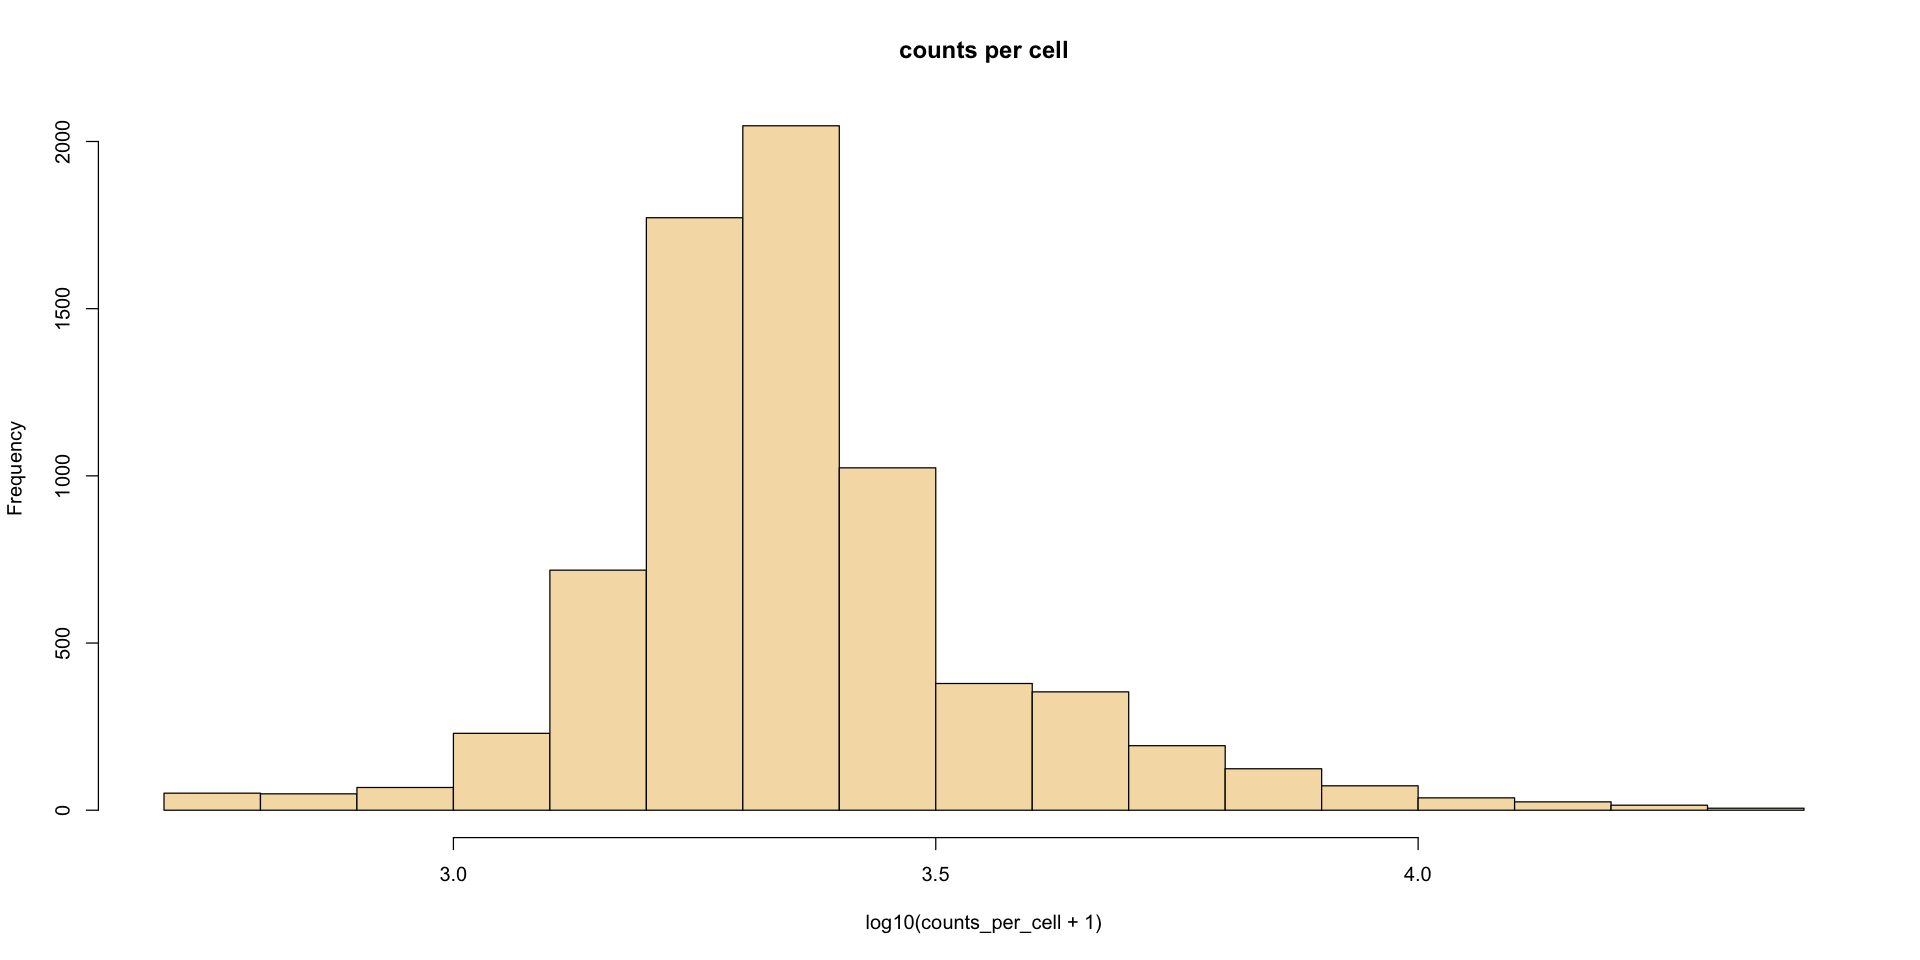

In [9]:
hist(log10(counts_per_cell+1), main='counts per cell', col='wheat')

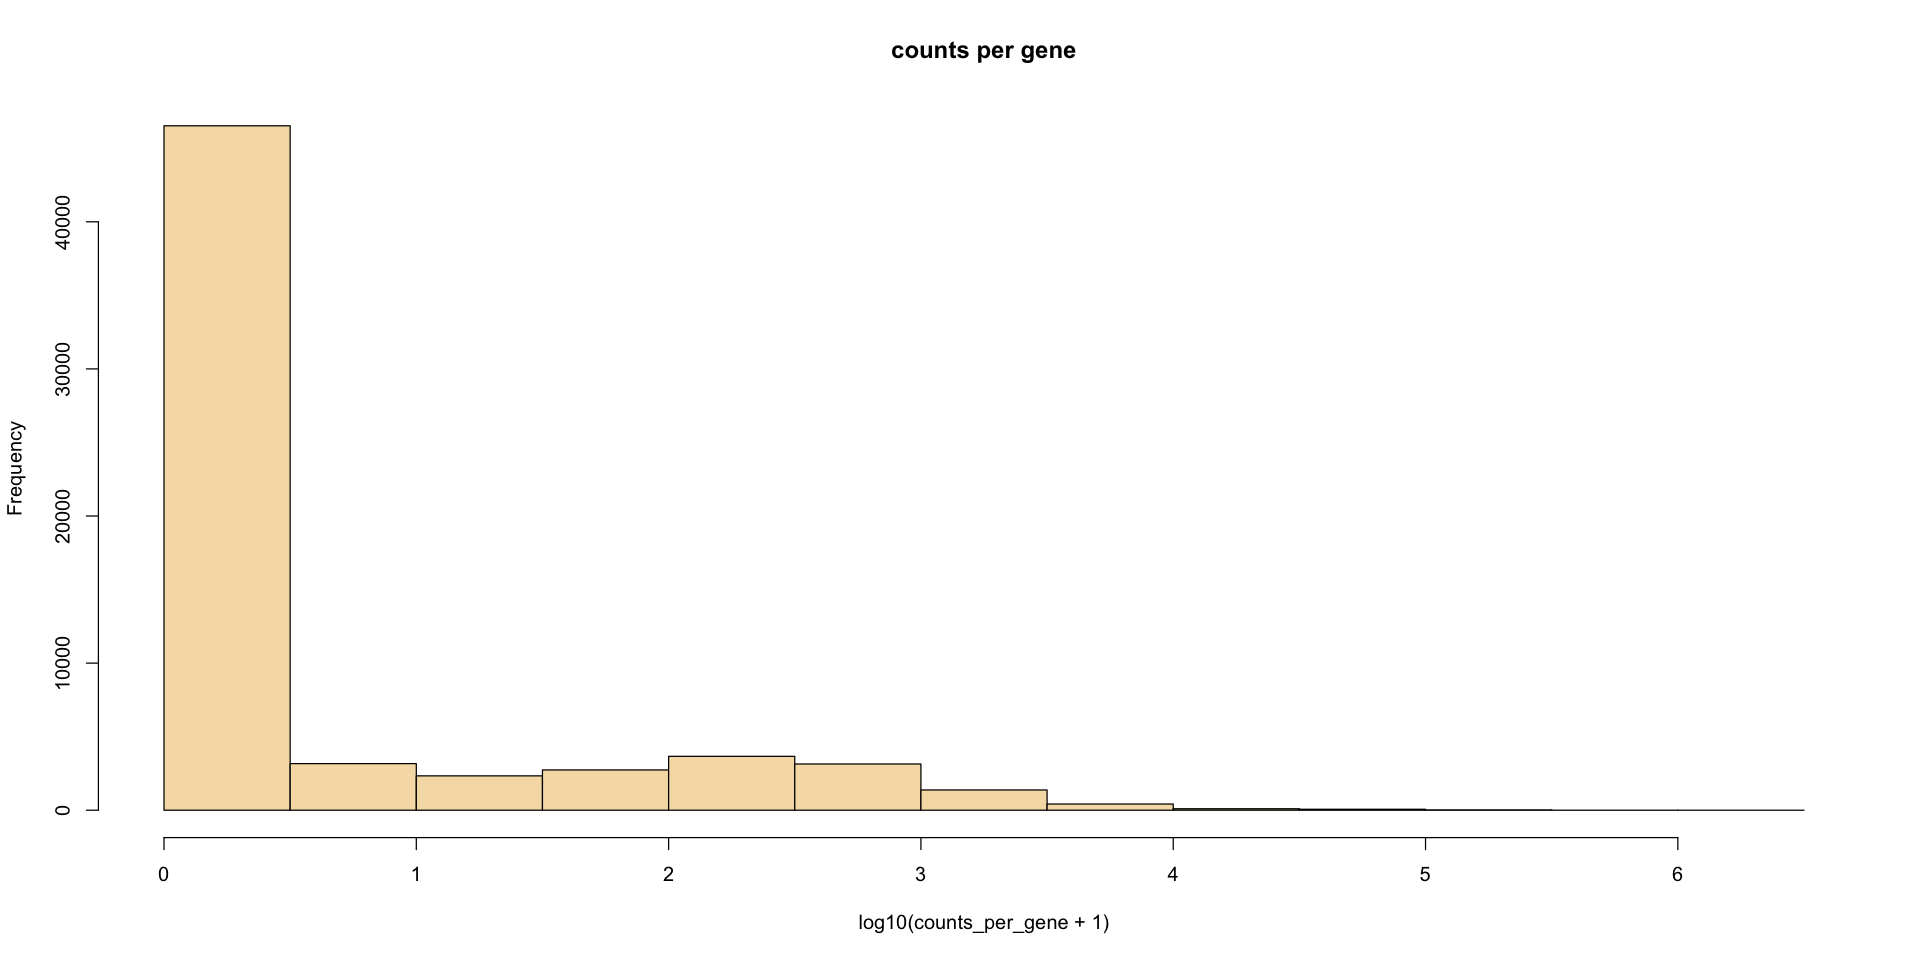

In [10]:
hist(log10(counts_per_gene+1), main='counts per gene', col='wheat')

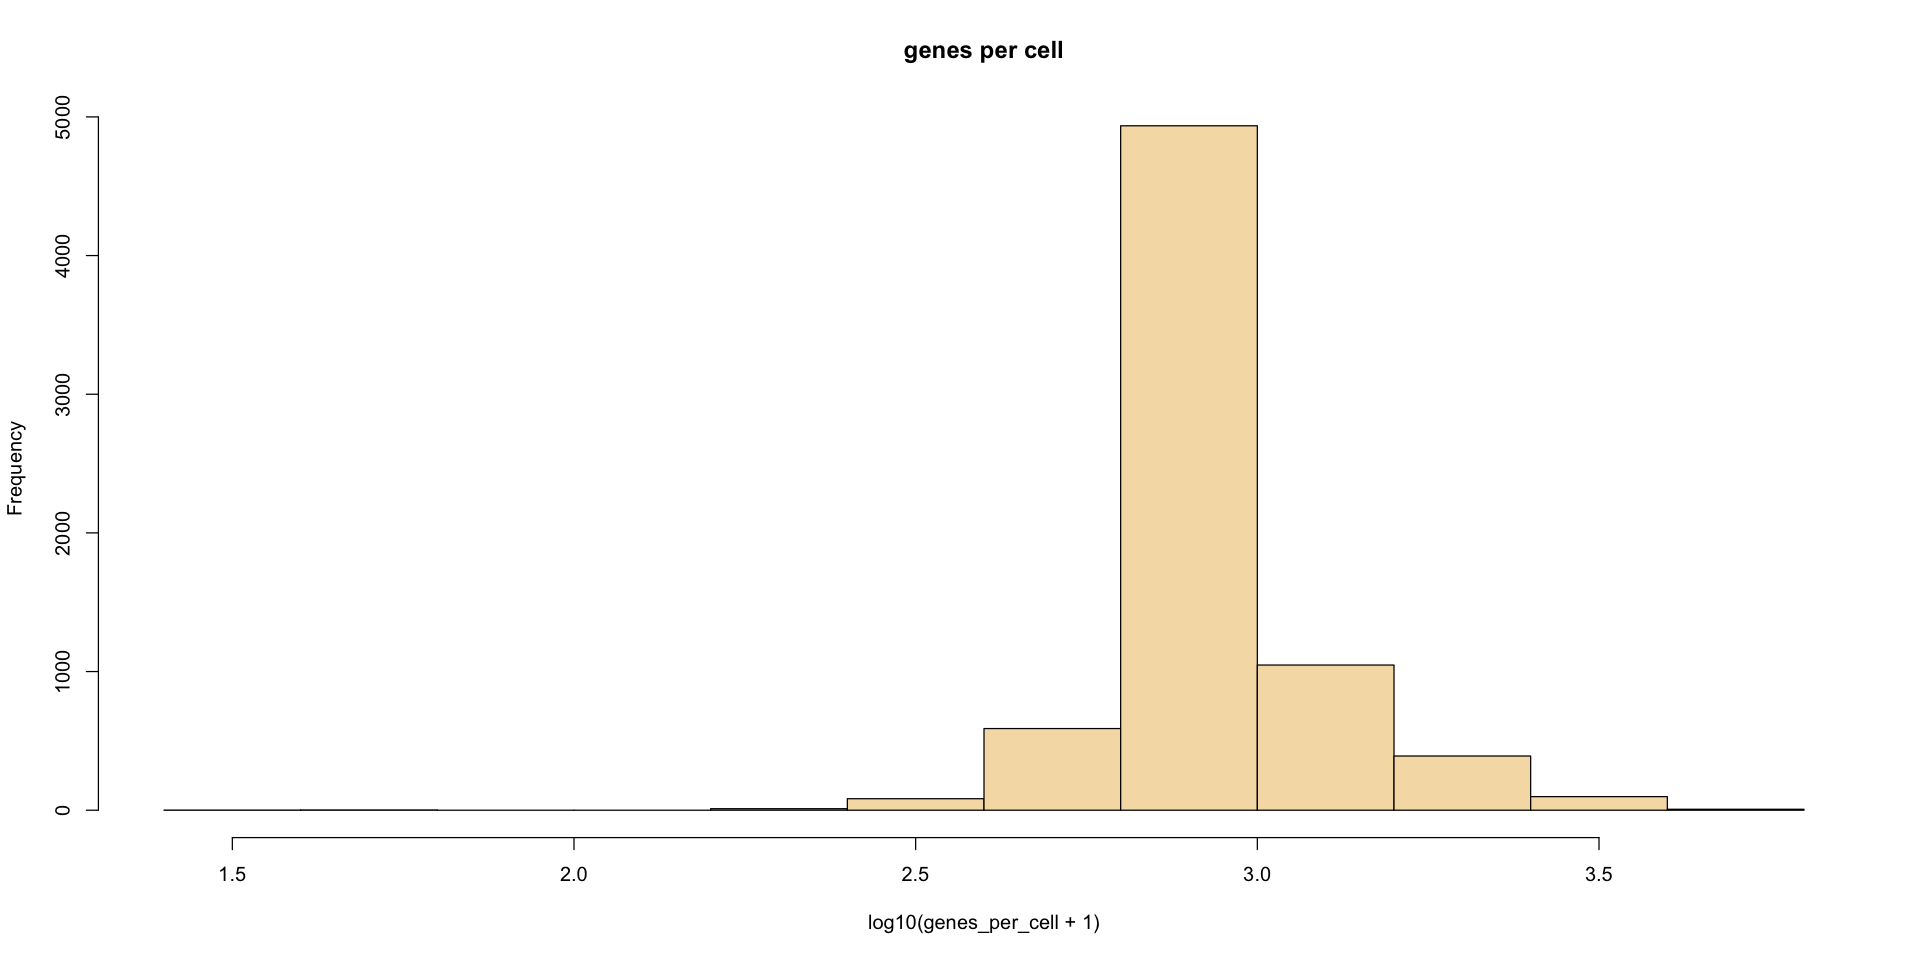

In [11]:
hist(log10(genes_per_cell+1), main='genes per cell', col='wheat')

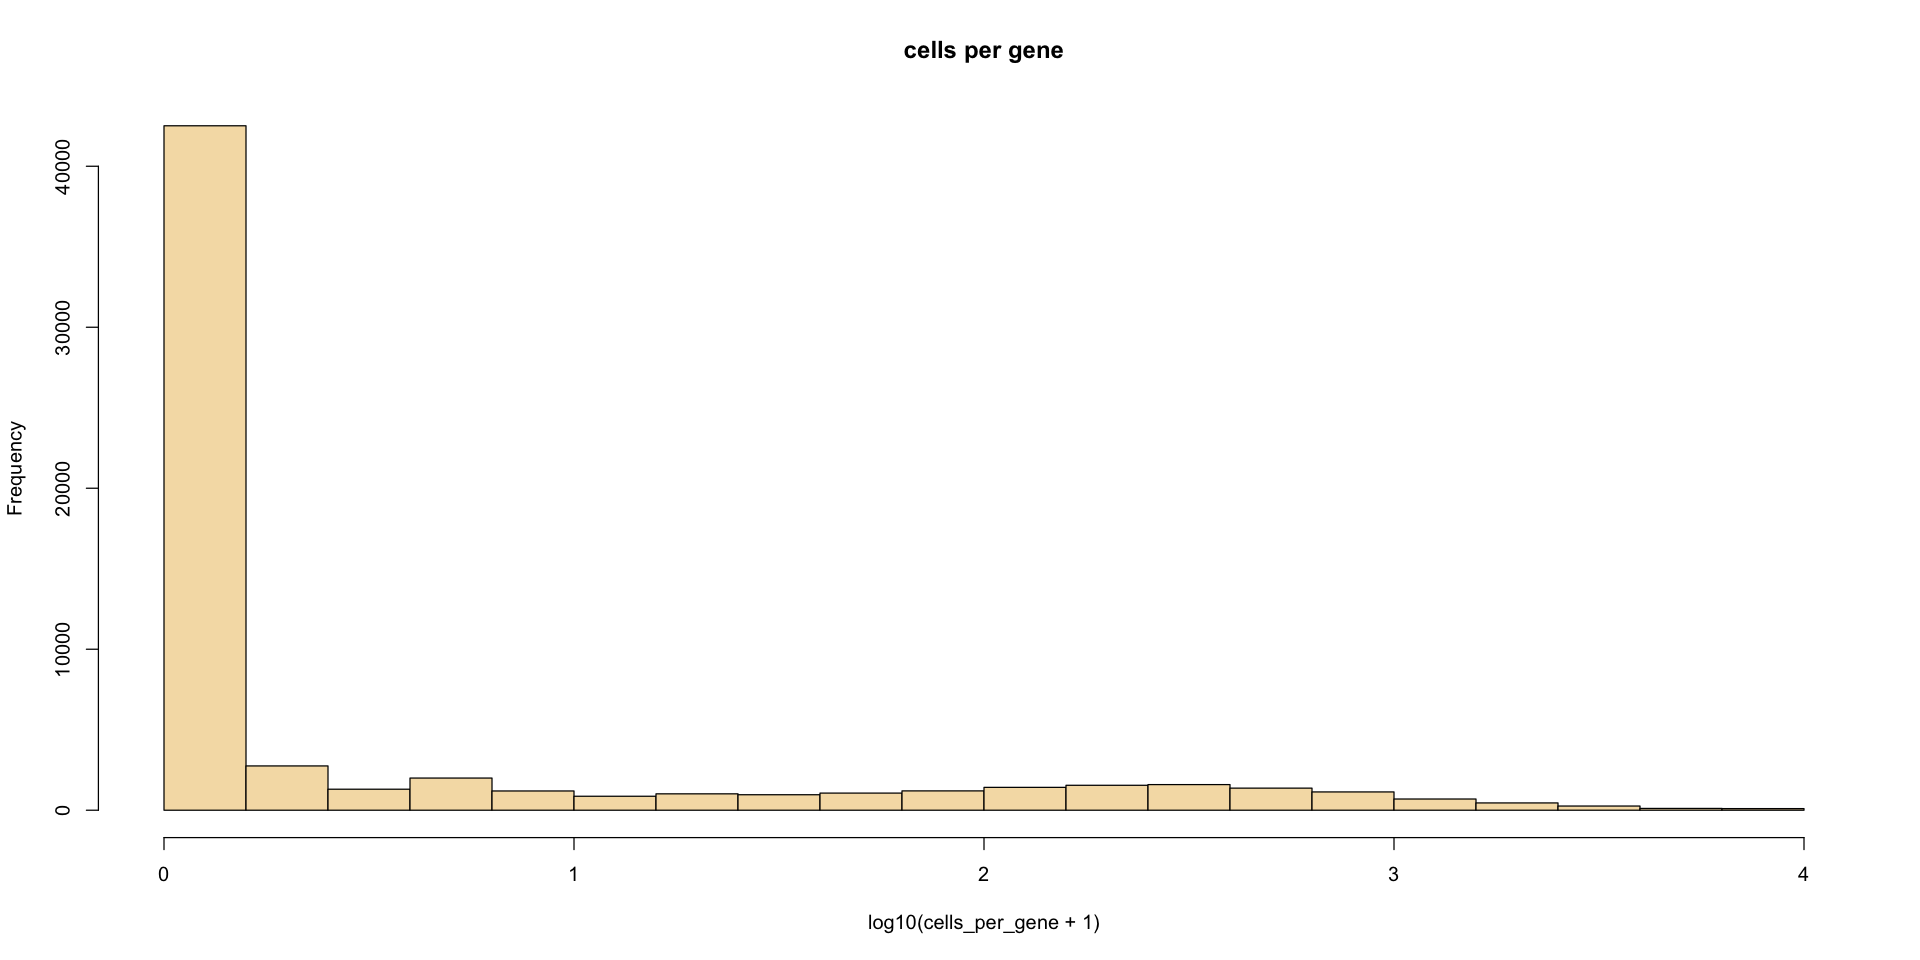

In [12]:
hist(log10(cells_per_gene+1), main='cells per gene', col='wheat')

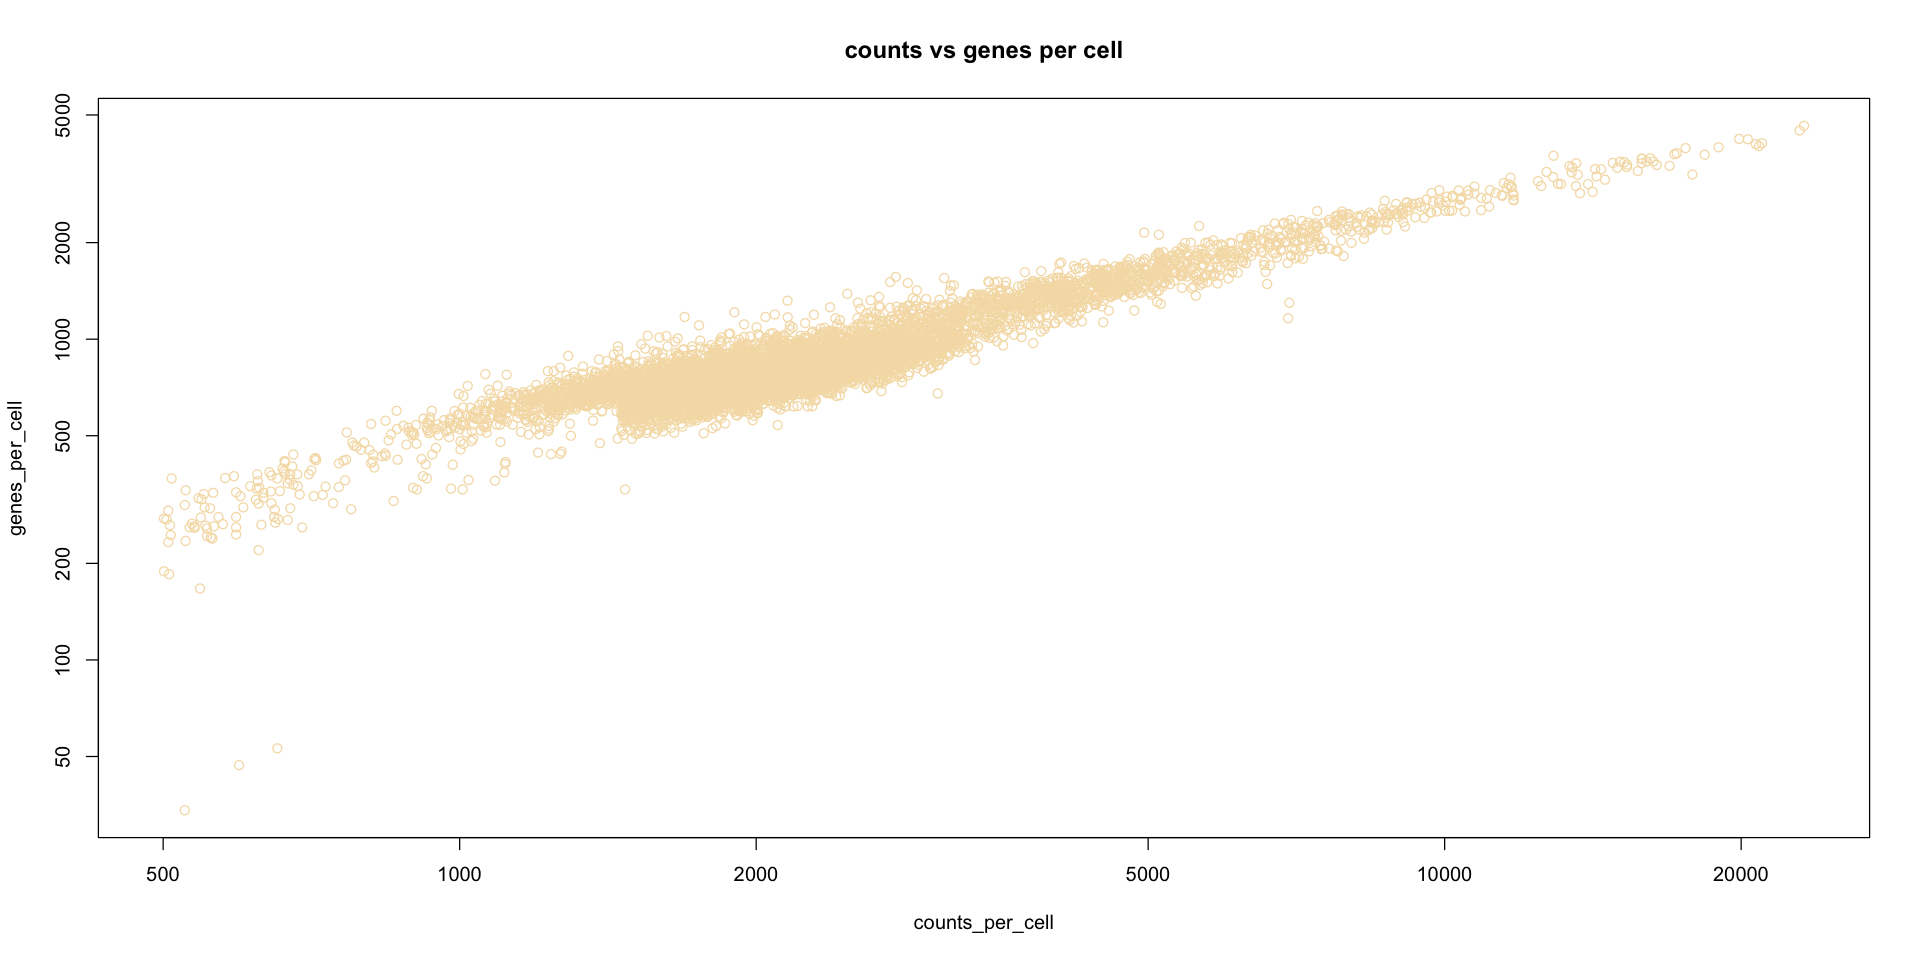

In [13]:
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell')

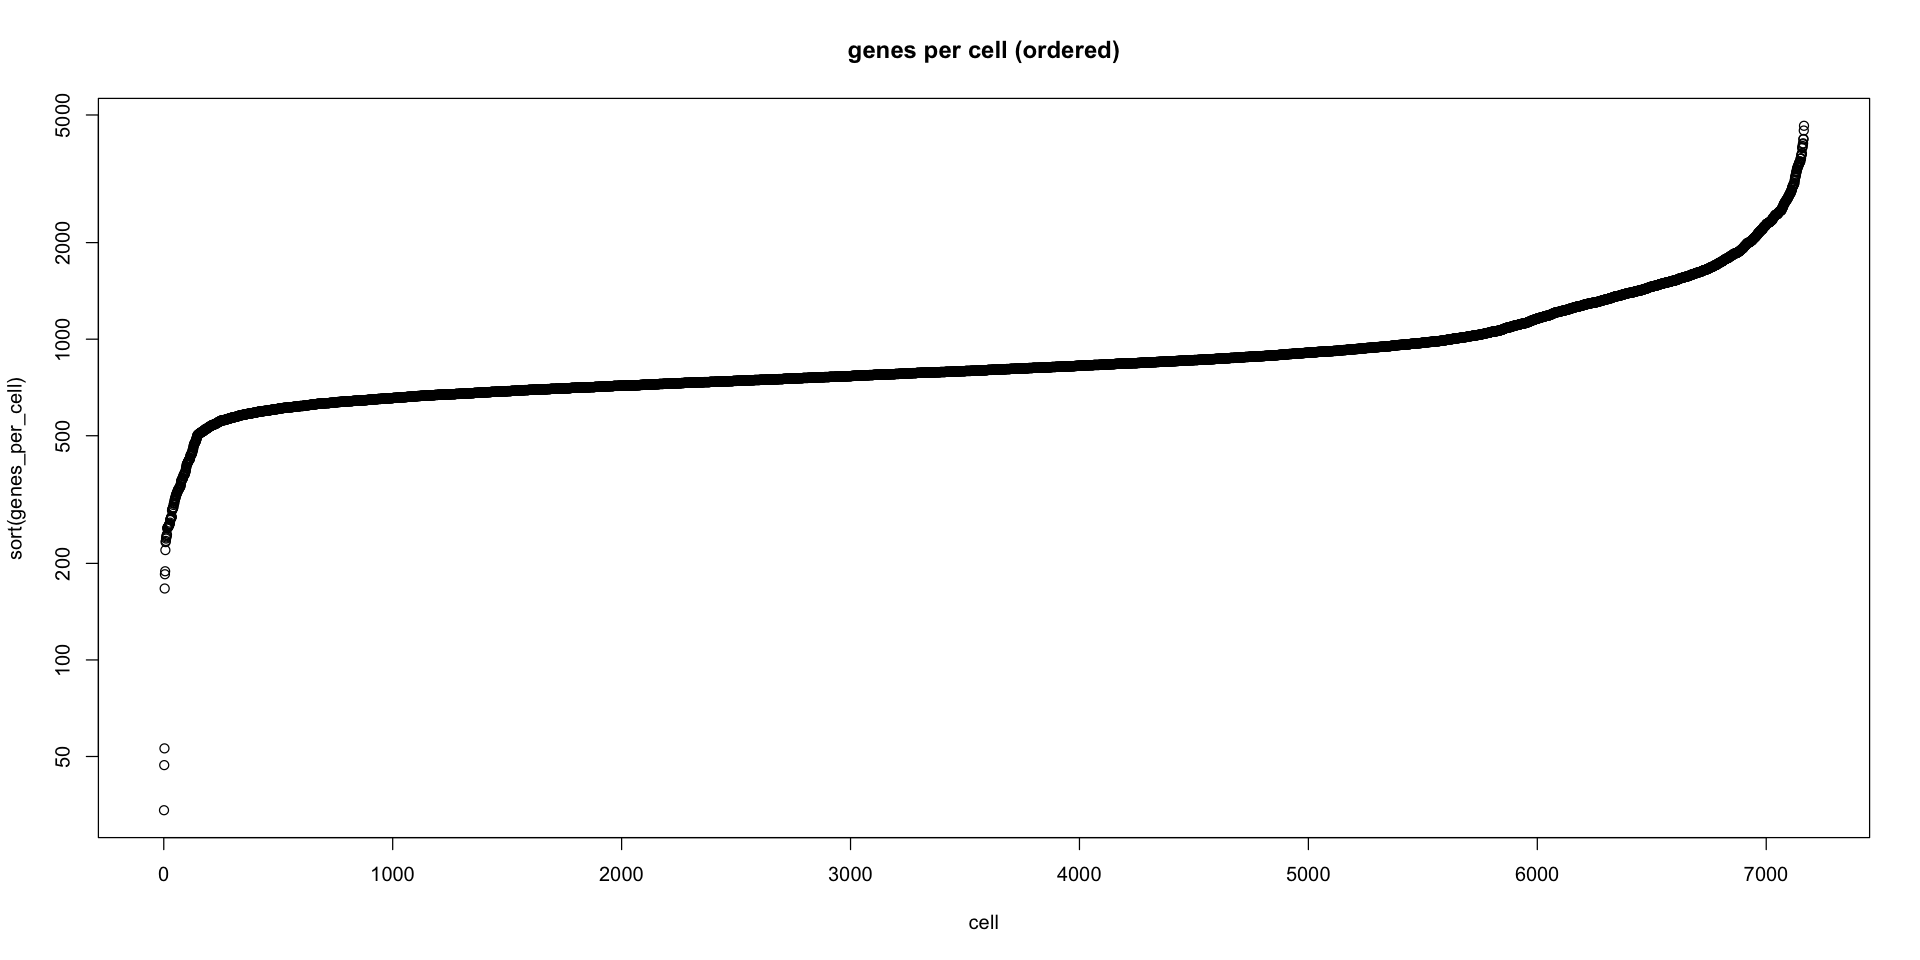

In [14]:
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')

In [15]:
dim(counts)

[1] 63568  7165

In [16]:
seurat<-CreateSeuratObject(counts = counts, min.cells = 3, min.features = 350, project = "FLU")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [17]:
dim(seurat)

[1] 16977  7092

In [18]:
seurat@assays$RNA@counts[1:30, 1:30]

   [[ suppressing 30 column names ‘AAACCTGAGATCGGGT-1’, ‘AAACCTGAGCCAGAAC-1’, ‘AAACCTGAGCGTGAAC-1’ ... ]]



30 x 30 sparse Matrix of class "dgCMatrix"
                                                                             
WASH7P         . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
CICP27         . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
AL627309.1     . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
AP006222.2     . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP4-669L17.10  . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP5-857K21.4   . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTND1P23       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTND2P28       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
hsa-mir-6723   . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTATP6P1       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP11-206L10.3  . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP11-206L10.2  . . . 

In [19]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  For non-UMI data, nUMI represents the sum of
# the non-normalized values within a cell We calculate the percentage of
# mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and
# non-log-normalized counts The % of UMI mapping to MT-genes is a common
# scRNA-seq QC metric.
mito.genes <- grep(pattern = "^MT-", x = rownames(x = seurat@assays$RNA@data), value = TRUE)
percent.mito <- Matrix::colSums(seurat@assays$RNA@data[mito.genes, ])/Matrix::colSums(seurat@assays$RNA@data)

# AddMetaData adds columns to object@meta.data, and is a great place to stash QC stats.
# This also allows us to plot the metadata values using the Seurat's VlnPlot().
head(seurat@meta.data) # Before adding

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCTGAGATCGGGT-1,FLU,1795,722
AAACCTGAGCCAGAAC-1,FLU,1099,541
AAACCTGAGCGTGAAC-1,FLU,2802,1065
AAACCTGCAAGCCGCT-1,FLU,1194,524
AAACCTGCACTTGGAT-1,FLU,4295,1489
AAACCTGCAGACGCAA-1,FLU,2211,840


,orig.ident,nCount_RNA,nFeature_RNA,percent.mito
,<fct>,<dbl>,<int>,<dbl>
AAACCTGAGATCGGGT-1,FLU,1795,722,0.01727019
AAACCTGAGCCAGAAC-1,FLU,1099,541,0.04367607
AAACCTGAGCGTGAAC-1,FLU,2802,1065,0.04925054
AAACCTGCAAGCCGCT-1,FLU,1194,524,0.10804020
AAACCTGCACTTGGAT-1,FLU,4295,1489,0.02048894
AAACCTGCAGACGCAA-1,FLU,2211,840,0.03889643


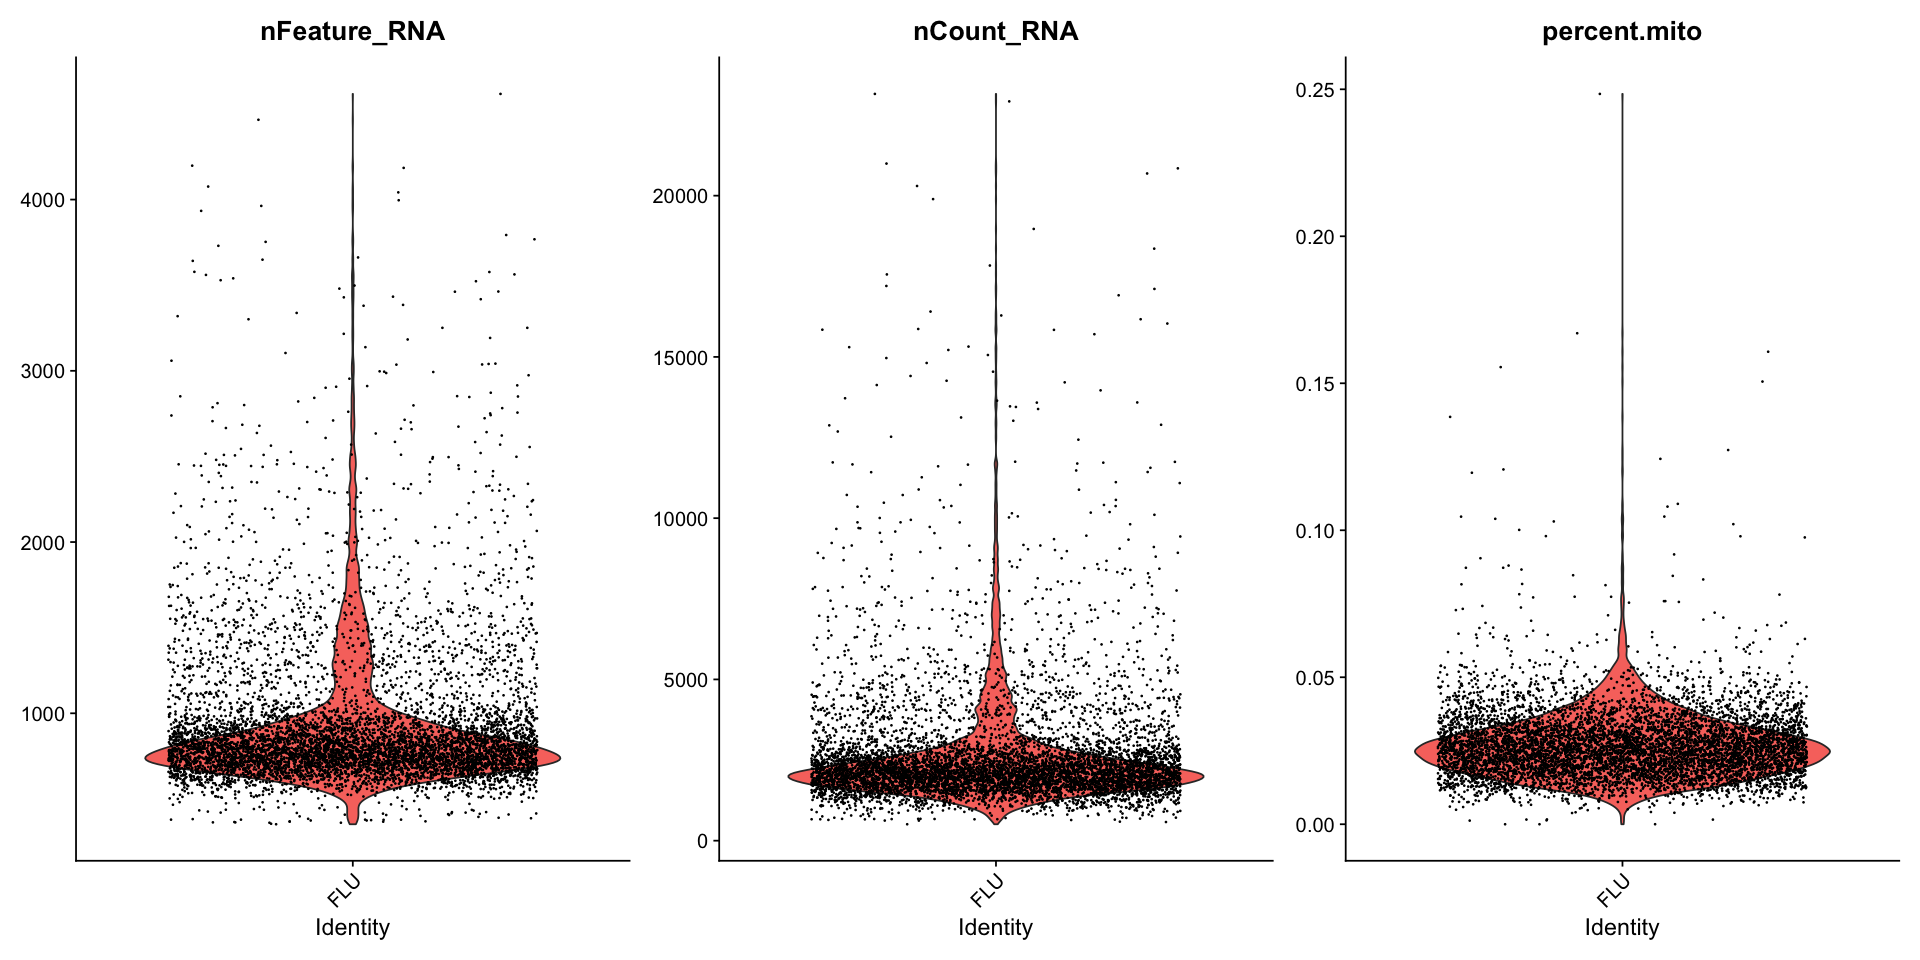

In [20]:
seurat <- AddMetaData(object = seurat, percent.mito, col.name = "percent.mito")
head(seurat@meta.data) # After adding
VlnPlot(object = seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"))

In [21]:
str(seurat)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6609320] 71 95 103 109 110 125 140 165 176 190 ...
  .. .. .. .. .. ..@ p       : int [1:7093] 0 722 1263 2328 2852 4341 5181 5790 6478 7160 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 16977 7092
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:16977] "WASH7P" "CICP27" "AL627309.1" "AP006222.2" ...
  .. .. .. .. .. .. ..$ : chr [1:7092] "AAACCTGAGATCGGGT-1" "AAACCTGAGCCAGAAC-1" "AAACCTGAGCGTGAAC-1" "AAACCTGCAAGCCGCT-1" ...
  .. .. .. .. .. ..@ x       : num [1:6609320] 1 1 1 1 1 2 1 1 1 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6609320] 71 95 103 109 110 12

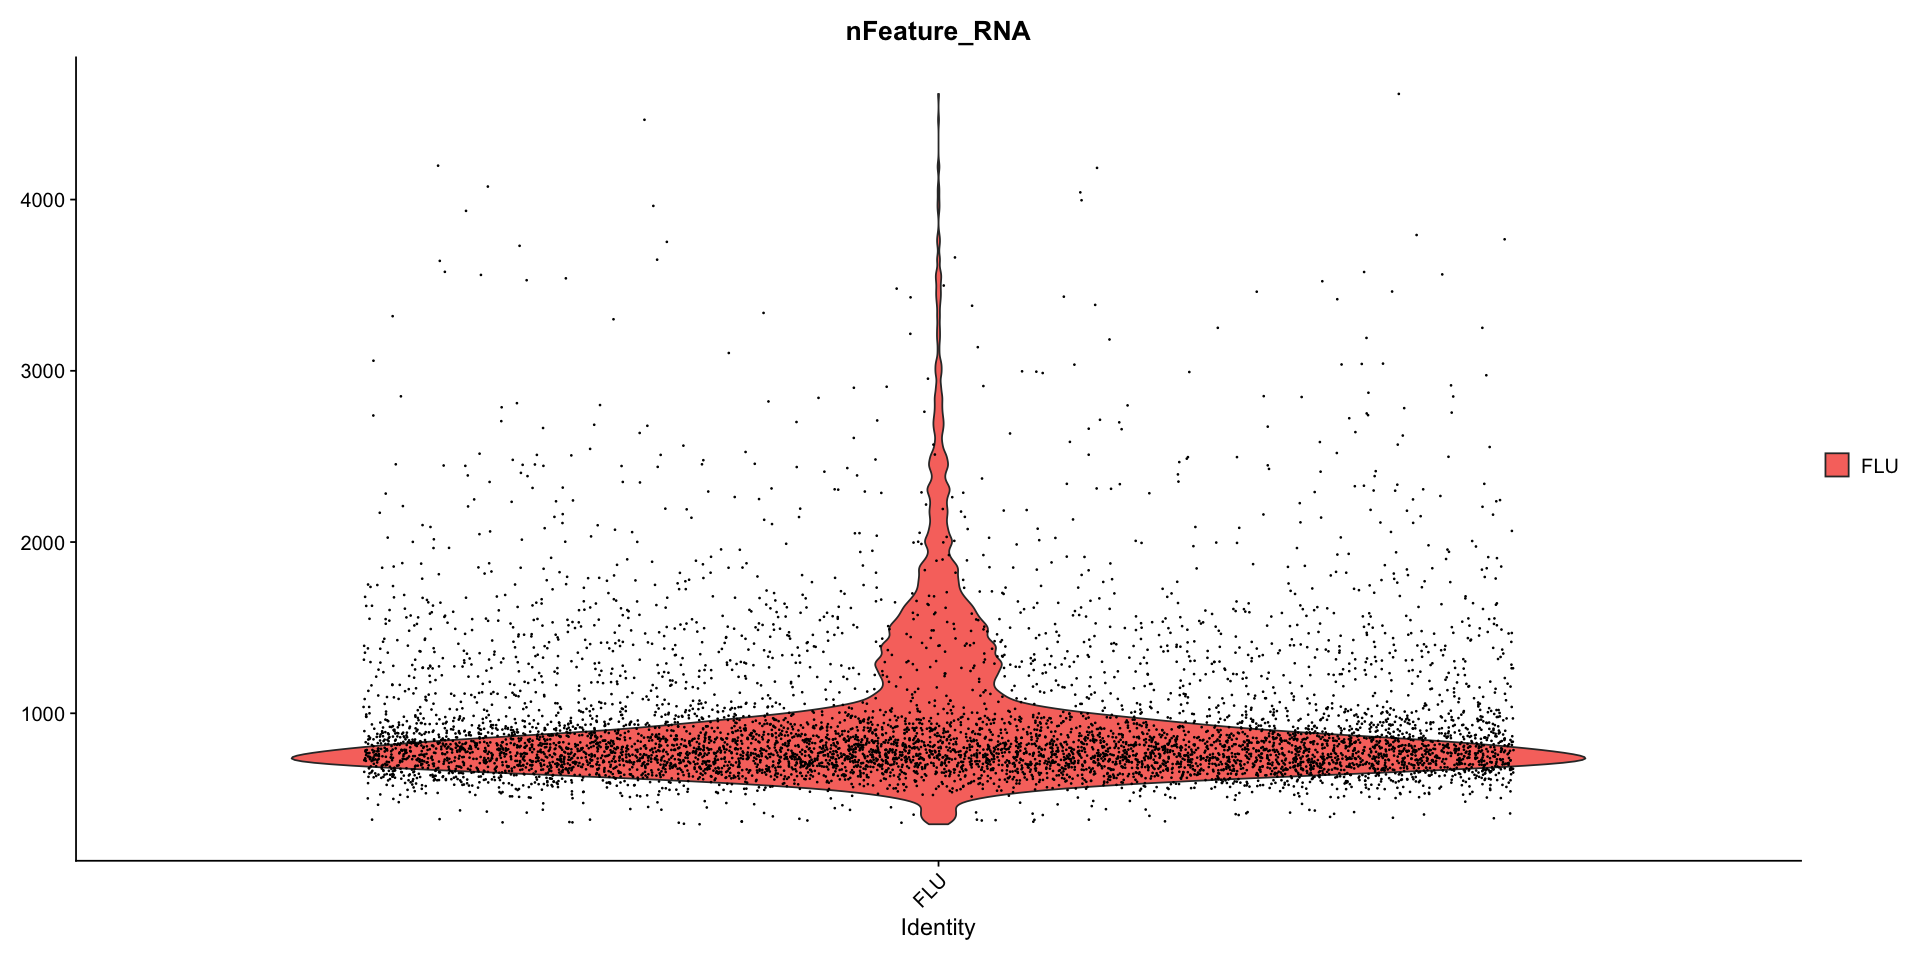

In [22]:
VlnPlot(object = seurat, features = c("nFeature_RNA"), group.by = c('orig.ident'))

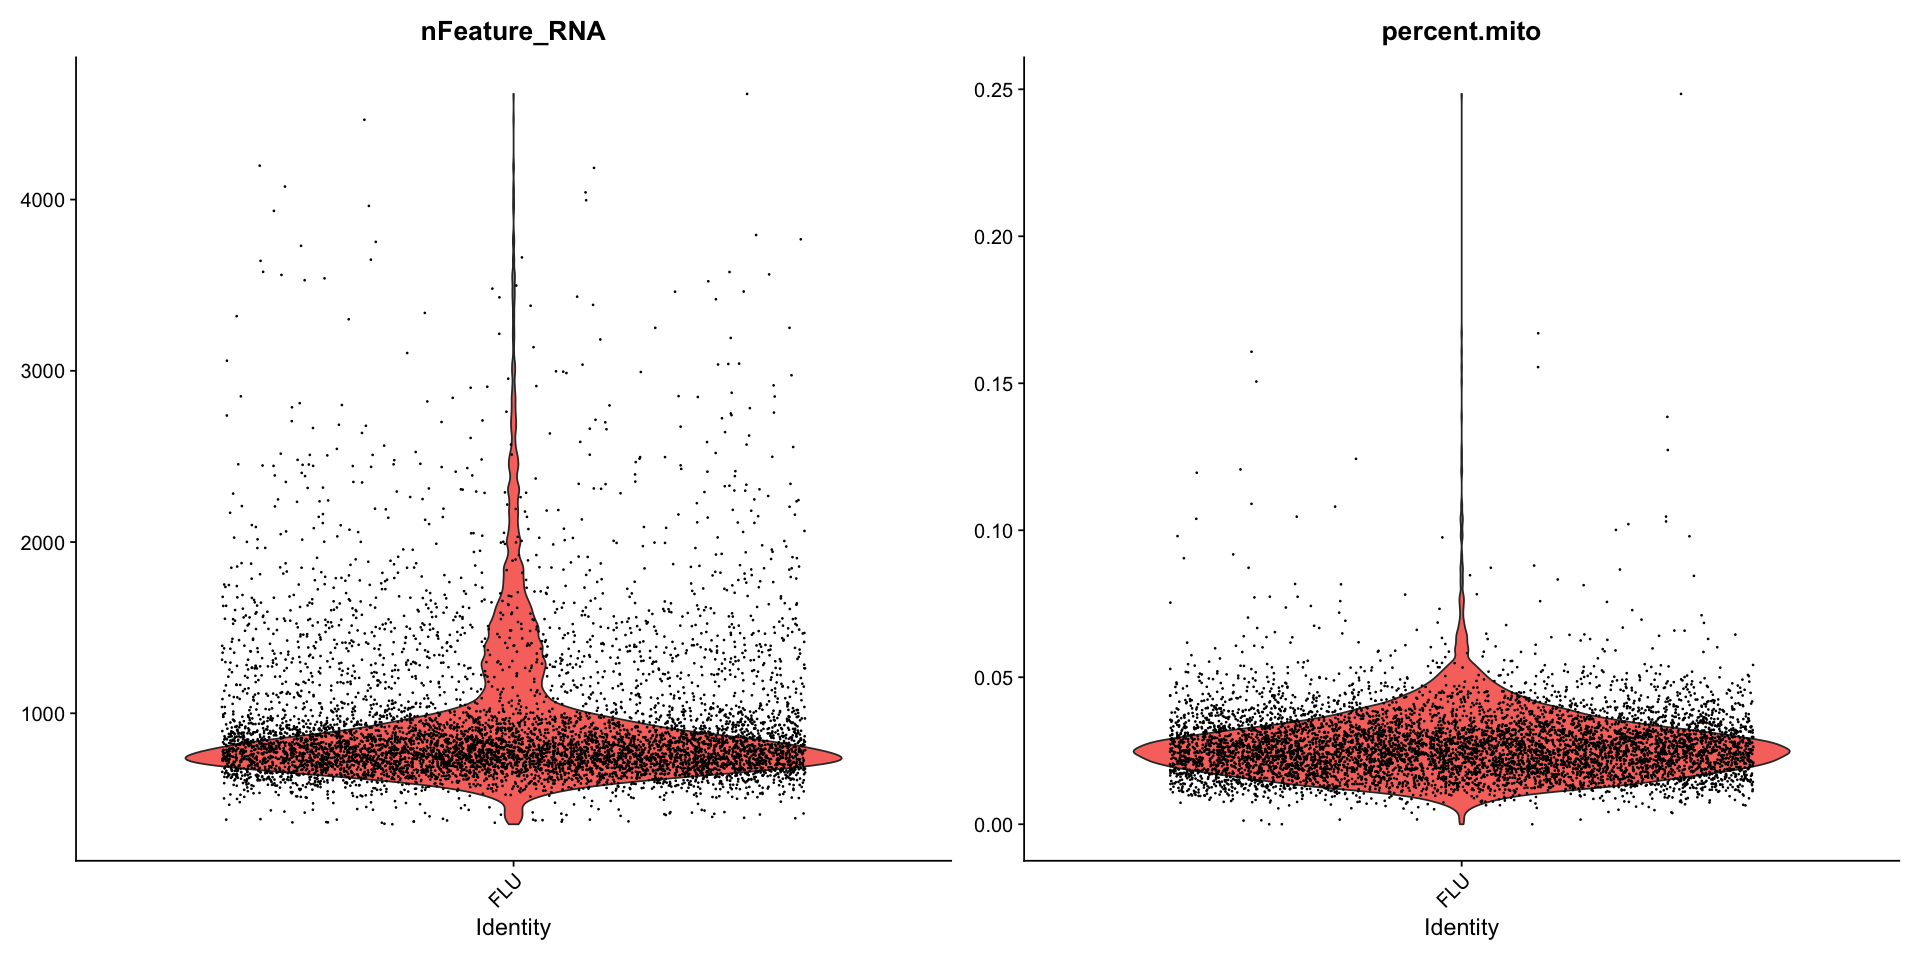

In [23]:
#VlnPlot(object = seurat, features = c("nFeature_RNA","percent.mito","n.exp.hkgenes"), ncol = 3)
VlnPlot(object = seurat, features = c("nFeature_RNA","percent.mito"), ncol = 2)

In [24]:
#seurat <- subset(seurat, subset = nFeature_RNA > 350 & nFeature_RNA < 4000 & percent.mito < 0.15 & n.exp.hkgenes > 55)

After demultiplexing cells into samples, Seurat (v3.1.5, R v3.6.3) was used to perform quality control filtering of cells. In total, we captured 255,731 cells prior to filtering (range of cells recovered per capture: min. = 5,534, max. = 10,805).


Cells were considered “high-quality” and retained for downstream analysis if they had: 
1) a “singlet” status called by souporcell, 
2) between 200 – 2500 genes detected (nFeature_RNA), and 
3) a mitochondrial reads percentage < 10%, leaving 236,993 cells (n = 19,248 genes).

In [25]:
seurat <- subset(seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mito < 0.1)

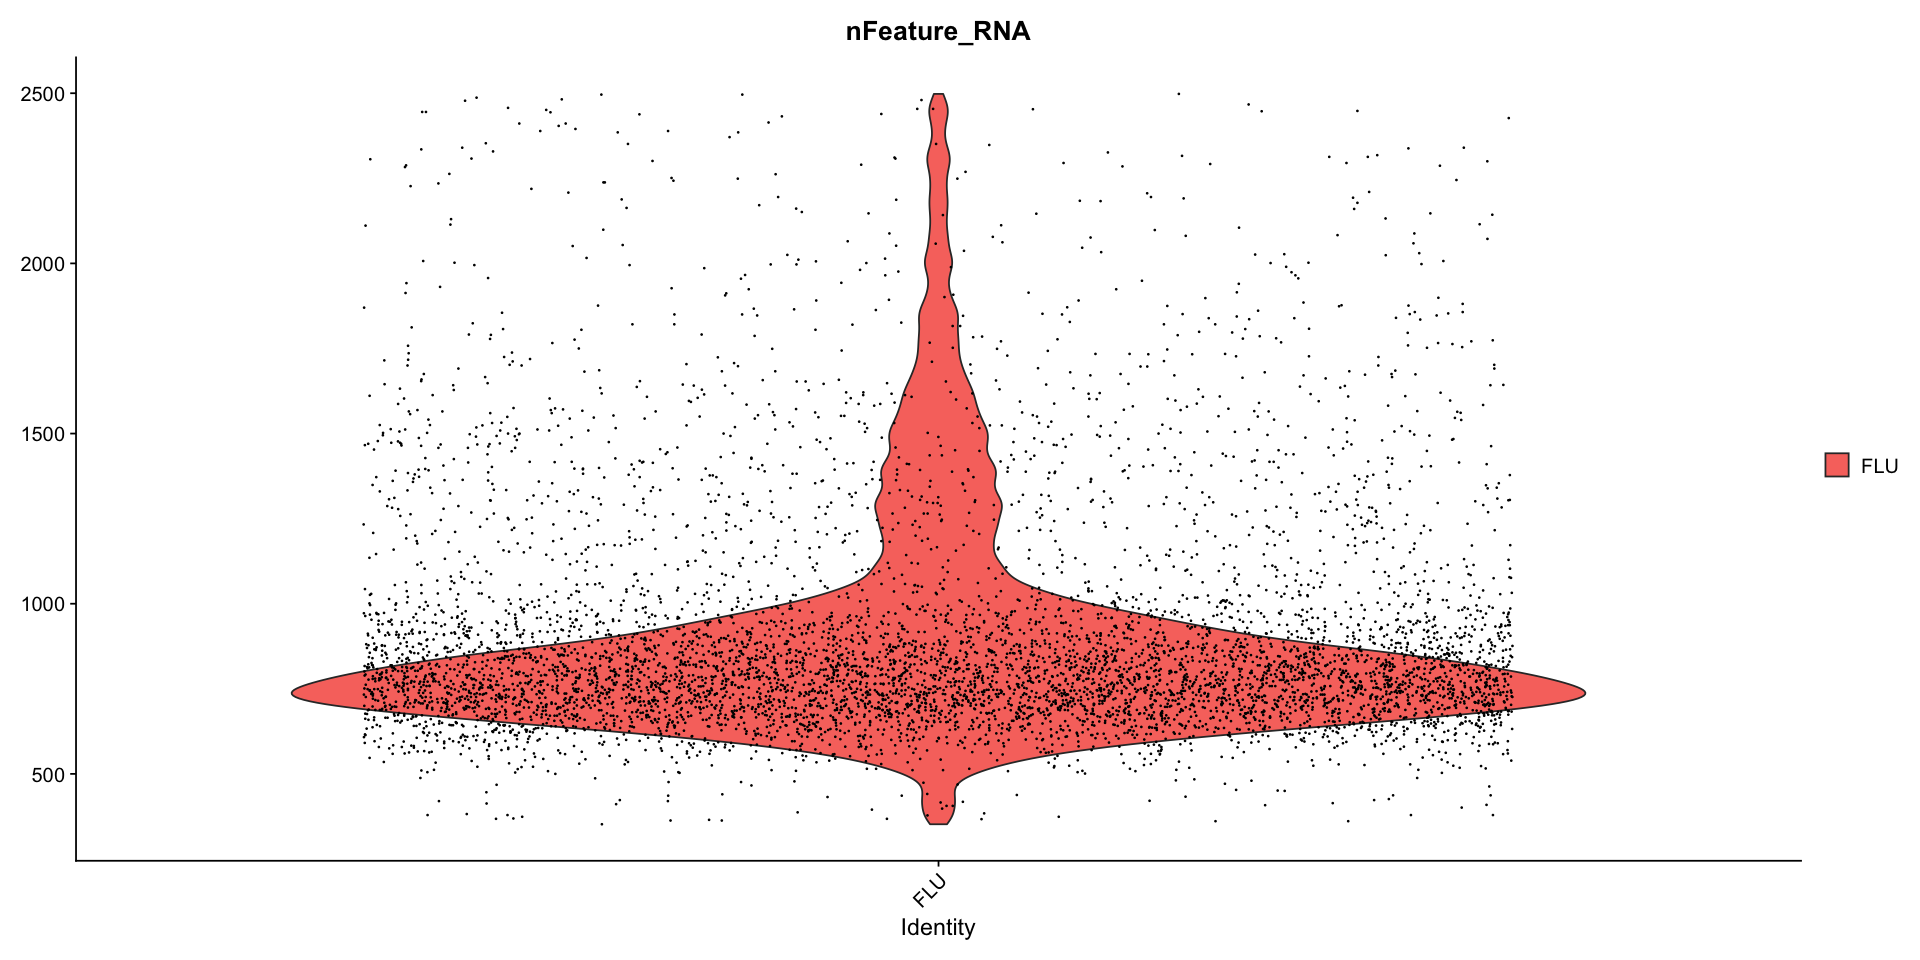

In [26]:
VlnPlot(object = seurat, features = c("nFeature_RNA"), group.by = c('orig.ident'))

In [27]:
seurat@assays$RNA@counts[1:30, 1:30]

   [[ suppressing 30 column names ‘AAACCTGAGATCGGGT-1’, ‘AAACCTGAGCCAGAAC-1’, ‘AAACCTGAGCGTGAAC-1’ ... ]]



30 x 30 sparse Matrix of class "dgCMatrix"
                                                                             
WASH7P         . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
CICP27         . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
AL627309.1     . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
AP006222.2     . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP4-669L17.10  . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP5-857K21.4   . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTND1P23       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTND2P28       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
hsa-mir-6723   . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTATP6P1       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP11-206L10.3  . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP11-206L10.2  . . . 

In [28]:
seurat <- NormalizeData(object = seurat, normalization.method = "LogNormalize", scale.factor = 1e4)

In [29]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge = 0, ynudge = 0)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


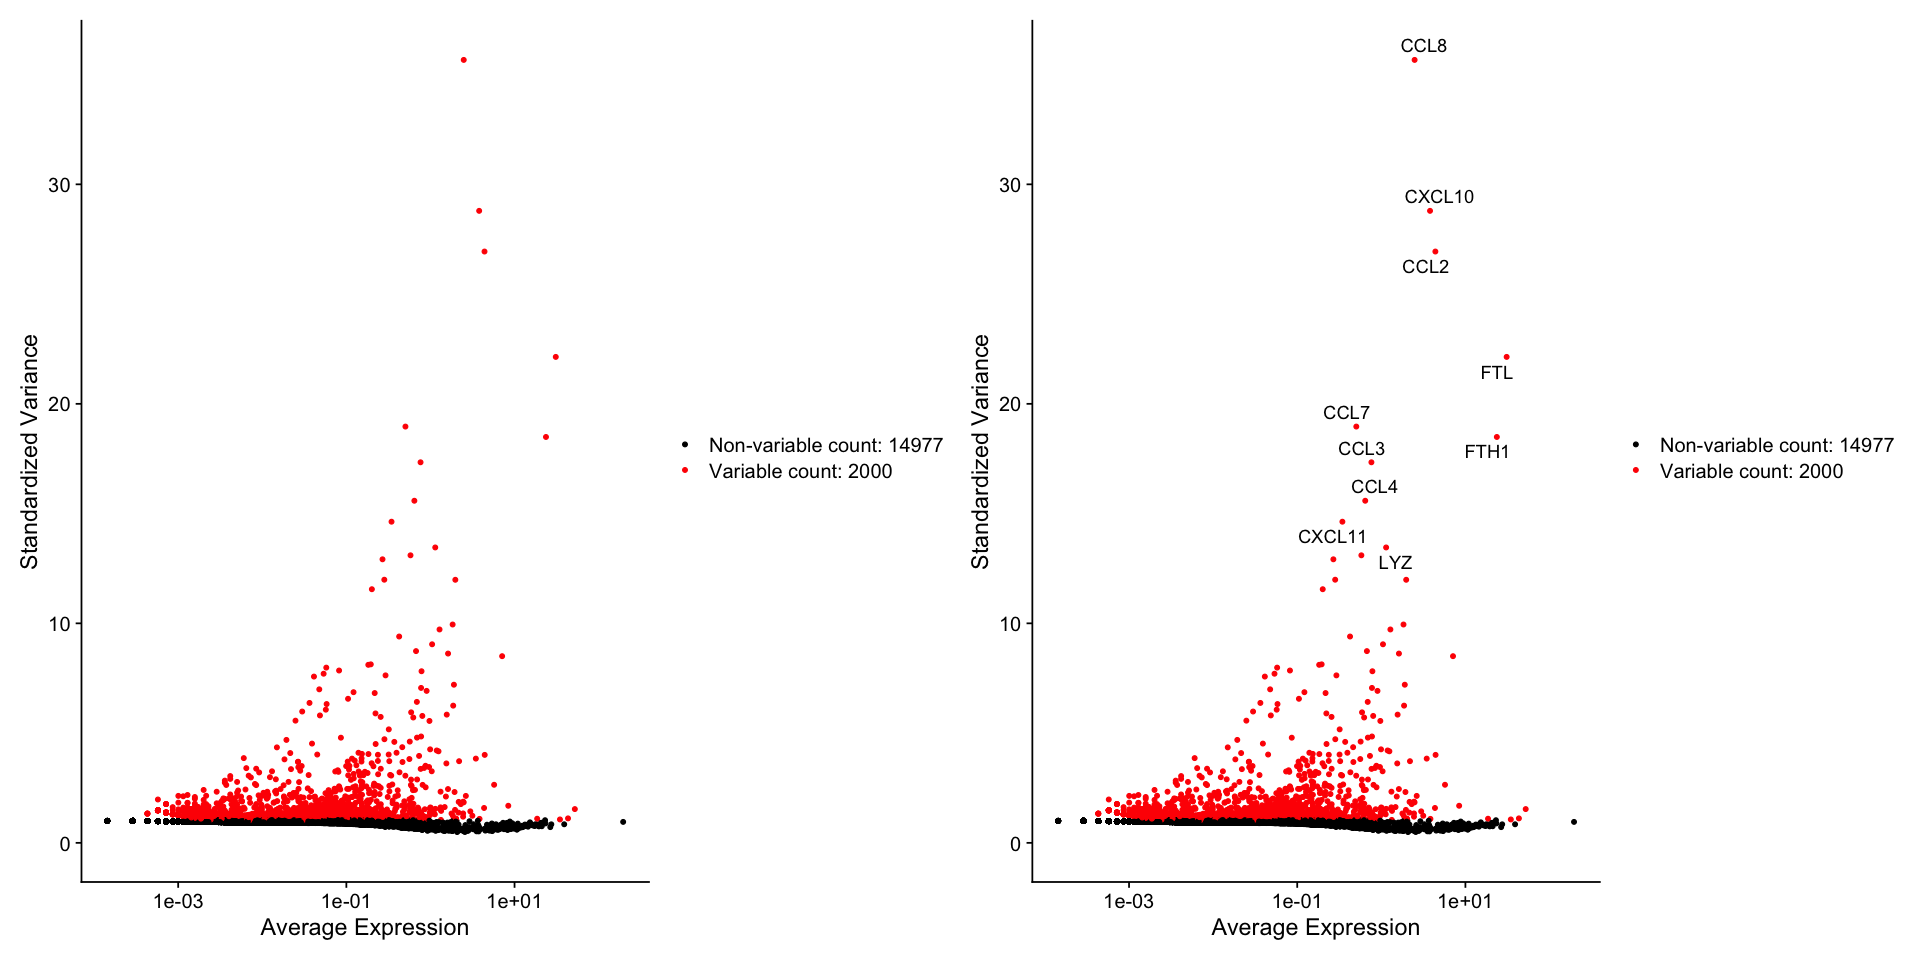

In [30]:
plot1 + plot2

In [31]:
dim(seurat)

[1] 16977  6968

In [32]:
## Read in a list of cell cycle markers, from Tirosh et al, 2015.
## We can segregate this list into markers of G2/M phase and markers of S phase.
#cc.genes <- readLines("data/resources/regev_lab_cell_cycle_genes.txt")
#s.genes <- cc.genes[1:43]
#g2m.genes <- cc.genes[44:97]
#seurat <- CellCycleScoring(seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [33]:
filtered_barcode_count=length(colnames(seurat@assays$RNA@data))
filtered_barcode_count

[1] 6968

In [34]:
head(colnames(seurat@assays$RNA@data))

[1] "AAACCTGAGATCGGGT-1" "AAACCTGAGCCAGAAC-1" "AAACCTGAGCGTGAAC-1"
[4] "AAACCTGCACTTGGAT-1" "AAACCTGCAGACGCAA-1" "AAACCTGGTAGAGCTG-1"

In [35]:
original_barcode_count - filtered_barcode_count

[1] 197

Combine this list of barcodes with souporcell's `clusters.tsv` in linking selection of bam reads.